### import libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(str('/home/alexandre/Documents/Projects'))

from slmOptim.patternSLM import patterns as pt
from slmOptim.optimization import phase_conjugation
from slmOptim.zeluxPy import helper_functions as cam
from slmOptim.optimization.init_experiment import InitExperiment
from slmOptim.optimization.iteration_algorithms import ContinuousSequential
from slmOptim.optimization.iteration_algorithms import StepwiseSequential



### set experiment parameters

In [11]:
# SLM resolution
resX, resY = (800, 600)

# the number of controlled segments on the SLM
slm_segments = 256

# size of macropixels on slm
slm_macropixels = 5

phase_steps = 8

# Define observation window on camera
roi_size = 800
off = (0, 0)

# Define camera macropixel, this is defined by the measured speckel grain
bins = 1

# Define camera acquisition parameters
exposure_time = 100
gain = 1
timeout= 100

### Initialize SLM and cam and do some checks


(804, 804)


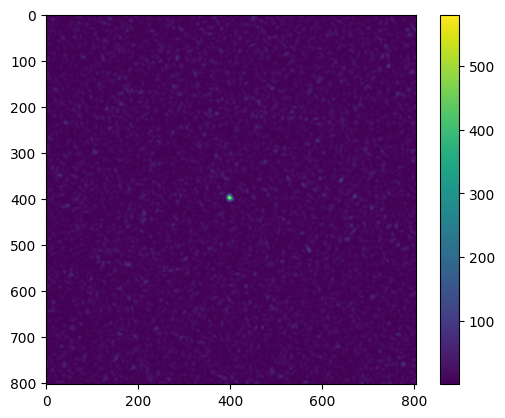

In [13]:
roi_size = 800
off = (0, 0)
bins = 1

init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
# slm = init.init_slm()

frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()
# init.close_cam()


print(frame.shape)

In [10]:
init.close_cam()

### define cost function

In [4]:
import numpy as np
from scipy.linalg import hadamard

# define target
target_shape = (104, 104)
tgt = phase_conjugation.Target(target_shape)
target = tgt.square((4, 4), offset_x=0, offset_y=0, intensity=100)

def corr_coef(X, Y):
    """ takes two 2d arrays, flattens them calculates the 
        corresponding covariance matrix. the correlation coefficient
        is calculated by r = cov(x, y) / sqrt(var(x) * var(y))
    """
    # flatten the input matrices
    x = X.flatten()
    y = Y.flatten()
    # stack them
    stacked = np.stack((x, y), axis=0)

    # calculate the covariance matrix
    covar = np.cov(stacked)
    # use the cov matrix elements to calculate correlation coefficient
    corr_coeff = covar[0, 1] / np.sqrt(covar[0, 0] * covar[1, 1])
    return corr_coeff

def intensity(X):
    intensity = X[399:401, 399:401].mean()
    return intensity
    

cost_fun = lambda x: corr_coef(x, target)
cost_fun = lambda x: intensity(x)


##### Load patterns that will be used for optimization using a custom pattern loader

In [5]:
pattern_loader = pt.OnePixelPatternGenerator(slm_segments)

#### run the algorithm

In [14]:
optim = StepwiseSequential(slm, camera, 
                           pattern_loader, 
                           total_iterations=3,
                           slm_segments=slm_segments,
                           slm_macropixel=slm_macropixels,
                           phase_steps=8)

optim.register_callback(cost_fun)
pattern, cost, frames = optim.run()

  0%|          | 0/256 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

  0%|          | 0/256 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

In [7]:
patternSLM = pt.Pattern(resX, resY)

temp = patternSLM._enlarge_pattern(pattern, 5)
temp = patternSLM.add_subpattern(temp)

slm.sendArray(temp)
# slm.updateArray(temp)

Data transmitted


1

In [8]:
frame = camera.get_pending_frame_or_null()
focus = np.copy(frame.image_buffer)

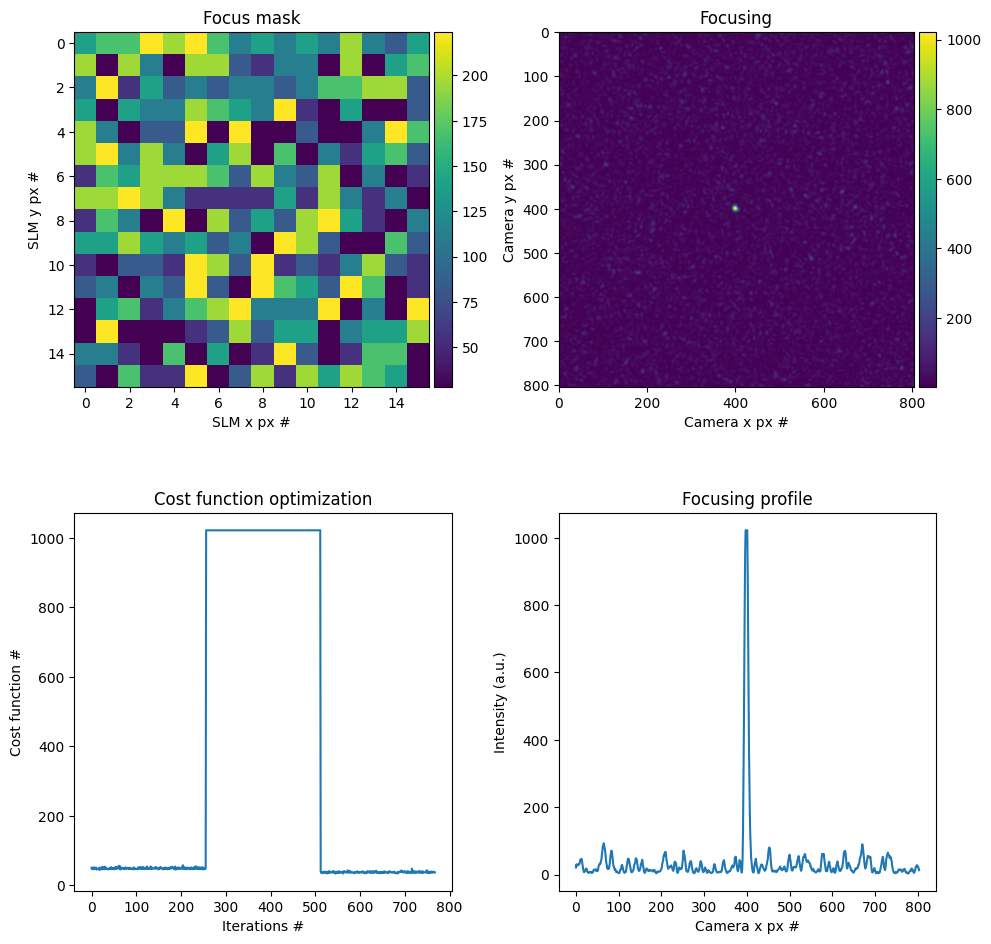

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(2, 2, figsize=(10, 10))

mask = axs[0, 0].imshow(pattern)
axs[0, 0].set_title("Focus mask")
axs[0, 0].set_xlabel("SLM x px #")
axs[0, 0].set_ylabel("SLM y px #")
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mask, cax=cax)

focus_img = axs[0, 1].imshow(focus)
axs[0, 1].set_title("Focusing")
axs[0, 1].set_xlabel("Camera x px #")
axs[0, 1].set_ylabel("Camera y px #")
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(focus_img, cax=cax)

axs[1, 0].plot(cost)
axs[1, 0].set_box_aspect(1)
axs[1, 0].set_title("Cost function optimization")
axs[1, 0].set_ylabel("Cost function #")
axs[1, 0].set_xlabel("Iterations #")

axs[1, 1].plot(focus[400])
axs[1, 1].set_box_aspect(1)
axs[1, 1].set_title("Focusing profile")

axs[1, 1].set_xlabel("Camera x px #")
axs[1, 1].set_ylabel("Intensity (a.u.)")


fig.tight_layout()
plt.savefig("continuous_sequential_algo.png", dpi=400, transparent=True)

In [ ]:
init.close_cam()
# init.close_slm()

In [ ]:
pat = pt.Pattern(resX, resY)
mirror = pat.mirror()
slm.sendArray(mirror)

In [ ]:
frame = camera.get_pending_frame_or_null()
focus = np.copy(frame.image_buffer)
plt.imshow(focus)
plt.colorbar()
plt.xlabel("Camera x px #")
plt.ylabel("Camera y px #")
plt.savefig("continuous_sequential_no_mask.png", dpi=400, transparent=True)

In [ ]:
# class StepwiseSequential2():
    
#     def __init__(self, 
#                  slm, 
#                  camera,
#                  pattern_loader,
#                  total_iterations=1,
#                  slm_segments=256,
#                  slm_macropixel=5, 
#                  slm_calibration_pixel=112,
#                  phase_steps=8,
#                  type='stepwise', 
#                  remote=True):
        
#         self.slm = slm
#         self.camera = camera
        
#         self.total_iterations = total_iterations

#         # slm settings
#         self.N = int(slm_segments ** 0.5)
#         self.slm_macropixel = slm_macropixel
#         self.calib_px = slm_calibration_pixel
        
#         self.pattern_loader = pattern_loader
                
#         self.m = phase_steps
        
#         # SLM
# #         resX, resY = slm.getSize()
#         resX, resY = (800, 600)
#         self.patternSLM = pt.Pattern(resX, resY)
        
#         # is the slm remotely connected to a rasp pi 
#         self.remote = remote
        
#         # type of algorithm
#         self.type = type
#         if type not in ['continuous', 'stepwise']:
#             raise Exception("sorry, type must be continuous or stepwise.")

        
     
#     def register_callback(self, callback):
#         """_summary_

#         Parameters
#         ----------
#         callback
#             _description_
#         """
#         self.callback = callback
    
#     def phi_k(self, k):
#         return (2 * (k + 1) / self.m) * self.calib_px
    
#     def create_pattern(self, k, pattern, mask):
        
#         phi = self.phi_k(k)
#         pattern[mask] = phi
#         temp = self.patternSLM._enlarge_pattern(pattern, self.slm_macropixel)
#         temp = self.patternSLM.add_subpattern(temp)
#         return temp

#     def upload_pattern(self, pattern, slm_delay=0.1):
#         if self.remote:
#             self.slm.sendArray(pattern)
#         else:
#             self.slm.updateArray(pattern)
#         time.sleep(slm_delay)
        
#     def update_pattern(self, pattern):
#         new_pattern = pattern
#         return new_pattern
    
#     def get_frame(self):
#         frame = self.camera.get_pending_frame_or_null()
#         image_buffer = np.copy(frame.image_buffer)
#         return image_buffer
        
#     def run(self):
#         gray = 0
#         final_pattern = np.array([[gray for _ in range(self.N)] for _ in range(self.N)]).astype('uint8')
#         final_pattern_k = final_pattern.copy()
        
#         cost = []
#         counter = 0
#         frames = {}

#         for iteration in range(0, self.total_iterations):   
#             temp_pattern = final_pattern.copy() 
#             # sweep each slm pixel
#             for _, mask, _ in tqdm((self.pattern_loader)):               
#                 corr = []
#                 # sweep phase at each pixel
#                 for k in np.arange(0, self.m):
#                     # create pattern, i.e one pattern for each phase value
#                     temp = self.create_pattern(k, temp_pattern, mask)
#                     # upload pattern to slm
#                     self.upload_pattern(temp, 0.1)
                    
#                     # get interferogram from camera
#                     frame = self.get_frame()

#                     # calculate correlation here
#                     corr_k = self.callback(frame)
#                     corr.append(corr_k)
                    
#                 counter += 1
#                 frames[counter] = frame
#                 temp_pattern = final_pattern.copy()
                
#                 # update pattern with max corr
#                 cost.append(np.max(corr))
#                 # pattern[idx[0], idx[1]] = self.phi_k(np.argmax(corr))
#                 final_pattern_k[mask] = self.phi_k(np.argmax(corr))
#             final_pattern = final_pattern_k.copy()

#         return final_pattern, cost, frames